In [1]:
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 64
num_classes = 10
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
train_set = datasets.CIFAR10('/content',train=True,download=True)
test_set = datasets.CIFAR10('/content',train=False,download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


### Preprocessing

In [4]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data
    dataset_labels = dataset.targets
    dataset_images = normalize(dataset_images)
    # dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Define the network

In [5]:
class NeuralNetwork(nn.Module):
  def __init__(self,classes,channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,4,5)
    self.conv2 = nn.Conv2d(4,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(6*5*5,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,classes)
  
  def forward(self,x):
    # x = x.unsqueeze(1)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    # x = F.softmax(x,dim=1)
    return x

### Training the model

In [6]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  model = model.to(device)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for _,(images,labels) in enumerate(trainloader):
      images,labels = images.to(device),labels.to(device)
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output,labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss / len(trainloader)}")
  return model

### Testing the model

In [7]:
def test(model,testloader,classes=2):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  model = model.to(device)
  with torch.no_grad():
    for images,labels in testloader:
      images,labels = images.to(device),labels.to(device)
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  # print(f"Accuracy for {classes} classes: {np.sum(correct) / np.sum(total)}")
  return correct[0] / total[0]

### Prepare initial training set

In [8]:
training_subset = {target: np.empty((0,3,32,32),dtype=np.float64) for target in range(num_classes)}


for image,label in zip(train_images,train_labels):
  image = np.transpose(image,(2,0,1,))
  training_subset[label] = np.vstack(([training_subset[label],[image]]))

### Prepare initial testing set

In [10]:
testing_subset = {target: np.empty((0,3,32,32),dtype=np.float64) for target in range(num_classes)}


for image,label in zip(test_images,test_labels):
  image = np.transpose(image,(2,0,1))
  testing_subset[label] = np.vstack(([testing_subset[label],[image]]))

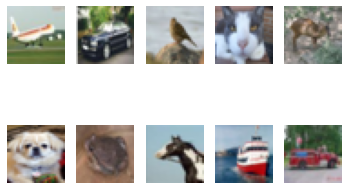

In [15]:
for i in range(num_classes):
  plt.subplot(2,5,i+1)
  plt.axis("off")
  plt.imshow(np.transpose(testing_subset[i][100],(1,2,0)))

In [18]:
training_subset[2].shape

(5000, 3, 32, 32)

In [20]:
accuracy_changes = [[] for x in range(num_classes)]

for class_of_interest in range(num_classes):
  # class_of_interest = 0
  print(f"Current target class: {class_of_interest}")

  multi_class_train_images = training_subset[class_of_interest].copy()
  multi_class_train_labels = np.zeros(multi_class_train_images.shape[0])
  multi_class_test_images = testing_subset[class_of_interest].copy()
  multi_class_test_labels = np.zeros(multi_class_test_images.shape[0])

  for i in range(num_classes):
    # prepare the dataset
    if i == class_of_interest:
      continue
    else:
      multi_class_train_images = np.vstack((multi_class_train_images,training_subset[i].copy()))
      multi_class_train_labels = np.append(multi_class_train_labels,np.ones(training_subset[i].shape[0]))

      multi_class_test_images = np.vstack((multi_class_test_images,testing_subset[i]))
      multi_class_test_labels = np.append(multi_class_test_labels,np.ones(testing_subset[i].shape[0]))

      # print(positive_train_images.shape)
      # print(negative_train_images.shape)
      train_tensor_x = torch.Tensor(multi_class_train_images)
      train_tensor_y = torch.Tensor(multi_class_train_labels)
      test_tensor_x = torch.Tensor(multi_class_test_images)
      test_tensor_y = torch.Tensor(multi_class_test_labels)
      train_dataset = TensorDataset(train_tensor_x,train_tensor_y.to(torch.int64))
      test_dataset = TensorDataset(test_tensor_x,test_tensor_y.to(torch.int64))

      train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
      test_loader = DataLoader(test_dataset,batch_size=batch_size)
      model = NeuralNetwork(2,3)
      model = train(model,train_loader)
      accuracy = test(model,test_loader)
      print(f"Accuracy of positive class after adding class {i}: {accuracy}")
      accuracy_changes[class_of_interest].append(accuracy)

Current target class: 0
Accuracy of positive class after adding class 1: 0.721
Accuracy of positive class after adding class 2: 0.523


KeyboardInterrupt: ignored

### Plot the accuracy variation for the class of interest


In [ ]:
plt.ylabel("Accuracy of target class")
plt.xlabel("Number of classes")
for i in range(num_classes):
  x = np.linspace(0,10,num=9)
  plt.plot(x,accuracy_changes[i],'-s',label = f'Class {i}')
# plt.plot(x,accuracy_change_1,'-s',label = 'Class 1')
plt.legend()
plt.title("Accuracy fluctuation")
plt.show()